Subcategory Significance (High Incidence): {'Top 25%': 9, 'With Secondary/Higher Education': 10, 'Urban': 10, 'Upper-Middle 25%': 1}
Subcategory Significance (Low Incidence): {'Upper-Middle 25%': 3, 'Without Secondary/Higher Education': 8, 'Rural': 5, 'Lower-Middle 25%': 6, 'Urban': 5, 'With Secondary/Higher Education': 2, 'Top 25%': 1}
                                    High-Incidence Weight  \
Top 25%                                               9.0   
With Secondary/Higher Education                      10.0   
Urban                                                10.0   
Upper-Middle 25%                                      1.0   
Without Secondary/Higher Education                    0.0   
Rural                                                 0.0   
Lower-Middle 25%                                      0.0   

                                    Low-Incidence Weight  Difference  
Top 25%                                                1         8.0  
With Secondary/Higher Educatio

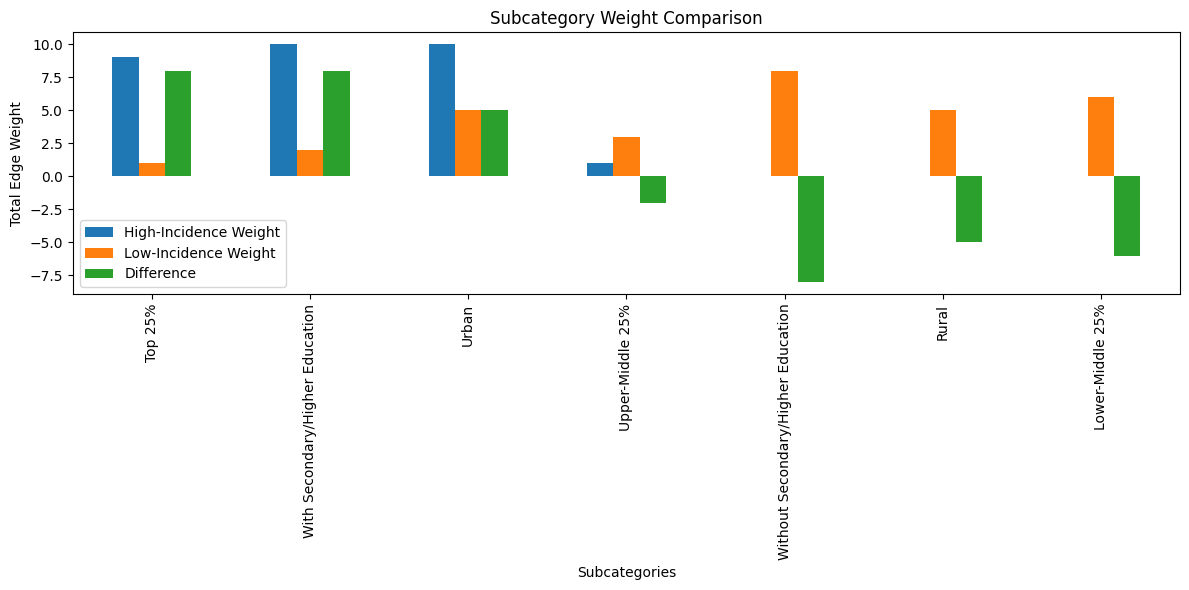

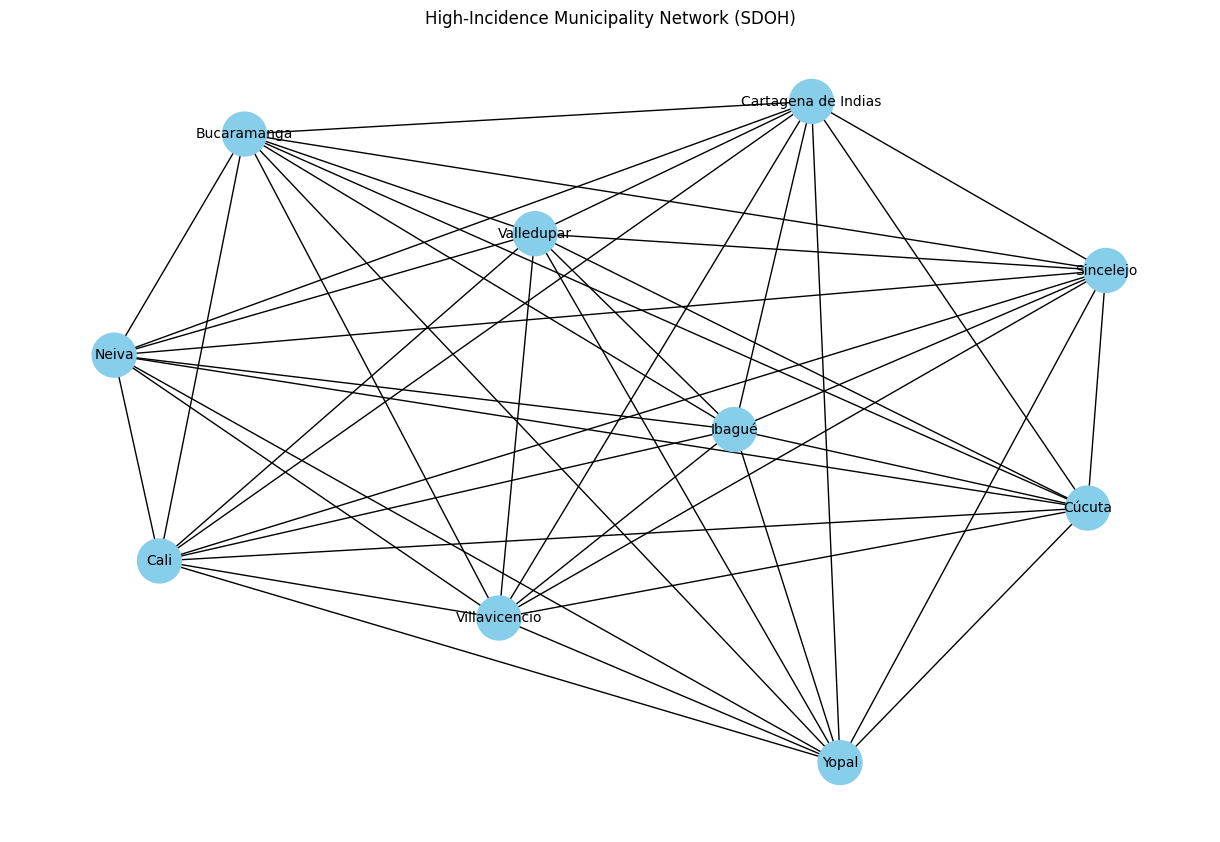

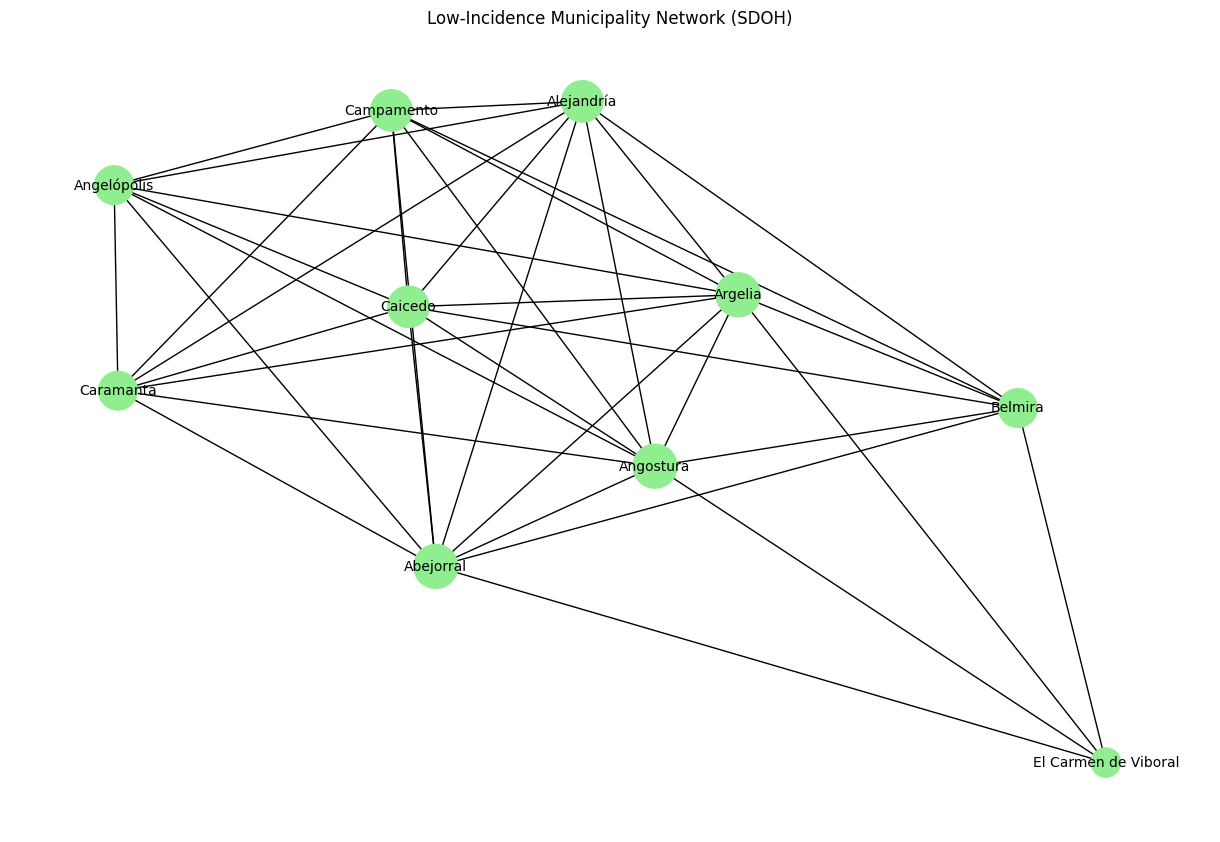

Top Municipalities by Degree Centrality (High Incidence):
[('Villavicencio', 1.0), ('Neiva', 1.0), ('Ibagué', 1.0), ('Cali', 1.0), ('Sincelejo', 1.0)]

Top Municipalities by Degree Centrality (Low Incidence):
[('Abejorral', 1.0), ('Angostura', 1.0), ('Argelia', 1.0), ('Alejandría', 0.8888888888888888), ('Caicedo', 0.8888888888888888)]

Average Clustering (High Incidence): 1.0
Average Clustering (Low Incidence): 0.9059523809523811


In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# STEP 1: LOAD AND PROCESS DATA
# Load the dataset
data = pd.read_csv("/Users/lilysorensen/Downloads/metadata.csv")

# Define sub-categories for housing density
def categorize_housing_density(value, quartiles):
    if value <= quartiles[0.25]:
        return "Bottom 25%"
    elif value <= quartiles[0.5]:
        return "Lower-Middle 25%"
    elif value <= quartiles[0.75]:
        return "Upper-Middle 25%"
    else:
        return "Top 25%"

# Define sub-categories for education level
def categorize_education(value, median):
    return "With Secondary/Higher Education" if value >= median else "Without Secondary/Higher Education"

# Define sub-categories for number of hospitals
def categorize_hospitals(value, median):
    return "Urban" if value >= median else "Rural"

# Compute quartiles and medians
housing_density_quartiles = data["NumberofhousesperKm2"].quantile([0.25, 0.5, 0.75])
education_median = data["Secondary/HigherEducation(%)"].median()
hospitals_median = data["NumberofhospitalsperKm2"].median()

# Add subcategories to the dataset
data["HousingDensityCategory"] = data["NumberofhousesperKm2"].apply(
    lambda x: categorize_housing_density(x, housing_density_quartiles)
)
data["EducationCategory"] = data["Secondary/HigherEducation(%)"].apply(
    lambda x: categorize_education(x, education_median)
)
data["HospitalsCategory"] = data["NumberofhospitalsperKm2"].apply(
    lambda x: categorize_hospitals(x, hospitals_median)
)

# STEP 2: CREATE NETWORKS
# Function to create a two-mode network
def create_two_mode_network(municipalities, data):
    B = nx.Graph()
    for _, row in municipalities.iterrows():
        municipality = row["Municipality"]
        B.add_node(municipality, type="municipality")
        # Add factor nodes and edges
        B.add_node(row["HousingDensityCategory"], type="factor")
        B.add_edge(municipality, row["HousingDensityCategory"])
        
        B.add_node(row["EducationCategory"], type="factor")
        B.add_edge(municipality, row["EducationCategory"])
        
        B.add_node(row["HospitalsCategory"], type="factor")
        B.add_edge(municipality, row["HospitalsCategory"])
    return B

# Separate municipalities into high and low dengue groups
high_incidence = data.nlargest(10, "Cases2019")
low_incidence = data.nsmallest(10, "Cases2019")

# Create two-mode networks
B_high = create_two_mode_network(high_incidence, data)
B_low = create_two_mode_network(low_incidence, data)

# STEP 3: PROJECT ONE-MODE NETWORKS
# Function to project a one-mode network
def project_one_mode_with_weights(bipartite_graph):
    one_mode = nx.Graph()
    for node in bipartite_graph.nodes():
        if bipartite_graph.nodes[node]["type"] == "factor":
            municipalities = list(bipartite_graph.neighbors(node))
            for i, u in enumerate(municipalities):
                for v in municipalities[i + 1:]:
                    if one_mode.has_edge(u, v):
                        one_mode[u][v]["weight"] += 1
                    else:
                        one_mode.add_edge(u, v, weight=1)
    return one_mode

# Create weighted one-mode networks
one_mode_high = project_one_mode_with_weights(B_high)
one_mode_low = project_one_mode_with_weights(B_low)

# STEP 4: CALCULATE SUBCATEGORY SIGNIFICANCE
# Function to calculate subcategory significance
def calculate_subcategory_significance(bipartite_graph):
    subcategory_weights = {}
    for node, attrs in bipartite_graph.nodes(data=True):
        if attrs["type"] == "factor":
            subcategory_weights[node] = sum(
                bipartite_graph[u][node].get("weight", 1) for u in bipartite_graph.neighbors(node)
            )
    return subcategory_weights

# Calculate subcategory significance
high_subcategory_significance = calculate_subcategory_significance(B_high)
low_subcategory_significance = calculate_subcategory_significance(B_low)

# Print results
print("Subcategory Significance (High Incidence):", high_subcategory_significance)
print("Subcategory Significance (Low Incidence):", low_subcategory_significance)

# STEP 5: COMPARE SUBCATEGORY WEIGHTS
comparison_table = pd.DataFrame({
    "High-Incidence Weight": high_subcategory_significance,
    "Low-Incidence Weight": low_subcategory_significance
}).fillna(0)

comparison_table["Difference"] = comparison_table["High-Incidence Weight"] - comparison_table["Low-Incidence Weight"]

# Display comparison
print(comparison_table)

# Plot comparison
comparison_table.plot.bar(figsize=(12, 6), title="Subcategory Weight Comparison")
plt.ylabel("Total Edge Weight")
plt.xlabel("Subcategories")
plt.tight_layout()
plt.show()

# STEP 6: VISUALIZE NETWORKS
# Function to visualize a network
def visualize_network(network, title, node_color):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(network)
    node_sizes = [v * 1000 for v in nx.degree_centrality(network).values()]
    nx.draw(network, pos, with_labels=True, node_size=node_sizes, node_color=node_color, font_size=10)
    plt.title(title)
    plt.show()

# Visualize networks
visualize_network(one_mode_high, "High-Incidence Municipality Network (SDOH)", "skyblue")
visualize_network(one_mode_low, "Low-Incidence Municipality Network (SDOH)", "lightgreen")

# STEP 7: ANALYZE CENTRALITY AND CLUSTERING
# Centrality
high_centrality = nx.degree_centrality(one_mode_high)
low_centrality = nx.degree_centrality(one_mode_low)

print("Top Municipalities by Degree Centrality (High Incidence):")
print(sorted(high_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

print("\nTop Municipalities by Degree Centrality (Low Incidence):")
print(sorted(low_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

# Clustering coefficients
high_clustering = nx.average_clustering(one_mode_high)
low_clustering = nx.average_clustering(one_mode_low)

print(f"\nAverage Clustering (High Incidence): {high_clustering}")
print(f"Average Clustering (Low Incidence): {low_clustering}")
